In [35]:
# !pip install pandas 
# !pip install numpy
# !pip install matplotlib
# !pip install tqdm
# !pip install seaborn
# !pip install tensorflow
# !pip install keras
!pip install scikit-learn

   ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
   - -------------------------------------- 0.2/9.3 MB 7.3 MB/s eta 0:00:02
   -- ------------------------------------- 0.6/9.3 MB 7.2 MB/s eta 0:00:02
   --- ------------------------------------ 0.9/9.3 MB 7.1 MB/s eta 0:00:02
   ----- ---------------------------------- 1.2/9.3 MB 7.1 MB/s eta 0:00:02
   ------ --------------------------------- 1.6/9.3 MB 7.2 MB/s eta 0:00:02
   -------- ------------------------------- 1.9/9.3 MB 7.2 MB/s eta 0:00:02
   --------- ------------------------------ 2.2/9.3 MB 7.2 MB/s eta 0:00:01
   ----------- ---------------------------- 2.6/9.3 MB 7.1 MB/s eta 0:00:01
   ------------ --------------------------- 2.9/9.3 MB 7.1 MB/s eta 0:00:01
   -------------- ------------------------- 3.3/9.3 MB 7.2 MB/s eta 0:00:01
   --------------- ------------------------ 3.6/9.3 MB 7.0 MB/s eta 0:00:01
   ---------------- ----------------------- 3.9/9.3 MB 7.0 MB/s eta 0:00:01
   ----------------

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import zipfile
import os
from tqdm import tqdm
import copy
import seaborn as sns
import sklearn

In [2]:
# Create documents dataframe
dp_docs = [file for file in os.listdir('dependency_treebank/') if file.endswith('.dp')]
dataframes = []

for file in tqdm(dp_docs):
    with open('dependency_treebank/' + file, 'r') as f:
        lines = f.readlines()
        data = [line.split('\t') for line in lines]
        df = pd.DataFrame(data, columns=['word', 'pos', 'head'])
        # drop the last column
        df = df.iloc[:, :-1]
        dataframes.append(df)

df = pd.DataFrame({'Dataframes': dataframes})
print(df.head(5))
print(df['Dataframes'][0][0:5])
print(df.shape)

100%|██████████| 199/199 [00:01<00:00, 113.21it/s]

                                          Dataframes
0              word   pos
0         Pierre   NNP
...
1              word  pos
0        Rudolph  NNP
1 ...
2           word   pos
0           A    DT
1     ...
3               word  pos
0          Yields  NNS
...
4                 word   pos
0              J.P. ...
     word  pos
0  Pierre  NNP
1  Vinken  NNP
2       ,    ,
3      61   CD
4   years  NNS
(199, 1)


In [3]:
# Split the dataframes into train, validation and test sets
train = df['Dataframes'][0:100]
val = df['Dataframes'][100:150]
test = df['Dataframes'][150:200]

print(train.shape)
print(val.shape)
print(test.shape)

(100,)
(50,)
(49,)


In [4]:
# Text preprocessing
def to_lower_case(df, docs):
    for i in range(docs, docs + len(df)):
        df[i]['word'] = df[i]['word'].str.lower()

to_lower_case(train, 0)
to_lower_case(val, 100)
to_lower_case(test, 150)
print(train[0][0:5])

     word  pos
0  pierre  NNP
1  vinken  NNP
2       ,    ,
3      61   CD
4   years  NNS


In [5]:
# Text preprocessing: from each doc remove newlines and empty lines
def remove_newlines(df, docs):
    for i in range(docs, docs + len(df)):
        df[i] = df[i][df[i]['word'] != '\n']
        df[i] = df[i][df[i]['word'] != '']

print(len(train[0]))
remove_newlines(train, 0)
remove_newlines(val, 100)
remove_newlines(test, 150)
print(train[0])
print(len(train[0]))
print(len(val[100]))
print(len(test[150]))

32
            word  pos
0         pierre  NNP
1         vinken  NNP
2              ,    ,
3             61   CD
4          years  NNS
5            old   JJ
6              ,    ,
7           will   MD
8           join   VB
9            the   DT
10         board   NN
11            as   IN
12             a   DT
13  nonexecutive   JJ
14      director   NN
15          nov.  NNP
16            29   CD
17             .    .
19           mr.  NNP
20        vinken  NNP
21            is  VBZ
22      chairman   NN
23            of   IN
24      elsevier  NNP
25          n.v.  NNP
26             ,    ,
27           the   DT
28         dutch  NNP
29    publishing  VBG
30         group   NN
31             .    .
31
827
220


In [6]:
# Create new dataframe that contains the single sentences
def create_sentences(df, docs):
    sentences = []
    chunks = []
    for i in range(docs, docs + len(df)):
        for element in df[i]['word']:
            if element != '.' and element != '!' and element != '?':
                chunks.append(element)
            else:
                chunks.append(element)
                sentences.append(chunks)
                chunks = []
    return sentences

# Create sentences for train, val and test
train_sentences = create_sentences(train, 0)
val_sentences = create_sentences(val, 100)
test_sentences = create_sentences(test, 150)
print(len(train_sentences))
print(len(val_sentences))
print(len(test_sentences))

1959
1277
638


In [7]:
def create_tag_sentences(df, docs):
    tag_sentences = []
    chunks = []
    for i in range(docs, docs + len(df)):
        for element in df[i]['pos']:
            if element != '.' and element != '!' and element != '?':
                chunks.append(element)
            else:
                chunks.append(element)
                tag_sentences.append(chunks)
                chunks = []
    return tag_sentences

# Create tag sentences for train, val and test
train_tag_sentences = create_tag_sentences(train, 0)
val_tag_sentences = create_tag_sentences(val, 100)
test_tag_sentences = create_tag_sentences(test, 150)
print(len(train_tag_sentences))
print(len(val_tag_sentences))
print(len(test_tag_sentences))


1959
1277
638


In [8]:
print(len(train_sentences[0]))
print(len(train_tag_sentences[0]))

18
18


In [10]:
# Encode train sentences and tags
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

sentence_tokenizer = Tokenizer(oov_token='<UNK>')
sentence_tokenizer.fit_on_texts(train_sentences)
encoded_train_sentences = sentence_tokenizer.texts_to_sequences(train_sentences)
encoded_val_sentences = sentence_tokenizer.texts_to_sequences(val_sentences)
encoded_test_sentences = sentence_tokenizer.texts_to_sequences(test_sentences)

print(f'OOV token: {sentence_tokenizer.oov_token}')
print(f'OOV index: {sentence_tokenizer.word_index[sentence_tokenizer.oov_token]}')
print(f'Vocabulary size: {len(sentence_tokenizer.word_index)}')
print(encoded_train_sentences[0])
print(encoded_val_sentences[0])
print(encoded_test_sentences[0])

OOV token: <UNK>
OOV index: 1
Vocabulary size: 7405
[3427, 2309, 2, 1744, 65, 343, 2, 41, 1371, 3, 192, 24, 7, 1120, 270, 708, 2310, 4]
[7, 1, 1033, 839, 298, 1, 5, 7, 1112, 10, 49, 55, 15, 392, 44, 8, 186, 1888, 10, 4437, 12, 1, 2348, 19, 15, 1, 44, 8, 508, 9, 1094, 1, 8, 1669, 260, 8, 1447, 5, 1, 576, 128, 9, 144, 4]
[1, 1, 99, 2, 1349, 5229, 2, 753, 2, 17, 18, 1238, 1, 44, 140, 2, 45, 43, 560, 38, 2, 5, 30, 168, 85, 35, 34, 1, 1031, 10, 15, 1, 7, 123, 2, 45, 15, 6185, 44, 4]


In [11]:
# I print and decode sentence 0
i = 2
print(encoded_train_sentences[i])
print(sentence_tokenizer.sequences_to_texts(encoded_train_sentences[i:i+1]))

[1746, 3430, 2, 959, 65, 343, 9, 497, 166, 5, 2311, 1121, 553, 1747, 2, 25, 448, 7, 1120, 270, 5, 46, 1122, 498, 3431, 4]
['rudolph agnew , 55 years old and former chairman of consolidated gold fields plc , was named a nonexecutive director of this british industrial conglomerate .']


In [12]:
tag_tokenizer = Tokenizer(oov_token='<UNK>')
tag_tokenizer.fit_on_texts(train_tag_sentences)
encoded_train_tags = tag_tokenizer.texts_to_sequences(train_tag_sentences)
encoded_val_tags = tag_tokenizer.texts_to_sequences(val_tag_sentences)
encoded_test_tags = tag_tokenizer.texts_to_sequences(test_tag_sentences)

print(f'Tag vocabulary size: {len(tag_tokenizer.word_index)}')
print(encoded_train_tags[0])

Tag vocabulary size: 46
[3, 3, 8, 12, 6, 7, 8, 21, 13, 5, 2, 4, 5, 7, 2, 3, 12, 9]


250


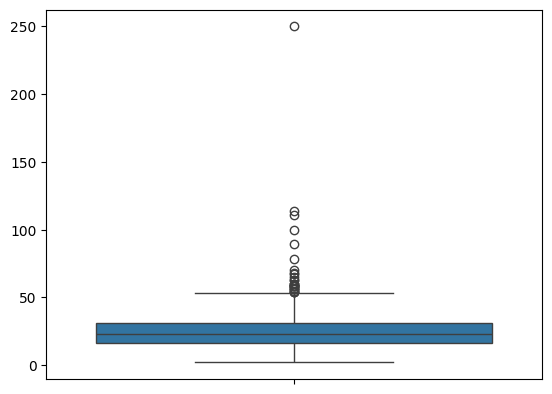

In [13]:
# check length of longest sentence 
lengths = [len(sentence) for sentence in encoded_train_sentences]
print(max(lengths))
sns.boxplot(lengths)
plt.show()

In [14]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS' pad_sequences() function. 
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = 100
train_padded = pad_sequences(encoded_train_sentences, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
train_tag_padded = pad_sequences(encoded_train_tags, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
val_padded = pad_sequences(encoded_val_sentences, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
val_tag_padded = pad_sequences(encoded_val_tags, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
test_padded = pad_sequences(encoded_test_sentences, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
test_tag_padded = pad_sequences(encoded_test_tags, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')

print(train_padded[0])
print(train_tag_padded[0])
print(len(train_padded[0]))
print(len(train_tag_padded[0]))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 3427 2309
    2 1744   65  343    2   41 1371    3  192   24    7 1120  270  708
 2310    4]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  3  3  8 12  6  7  8 21 13  5  2  4  5  7
  2  3 12  9]
100
100


In [15]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    download_path = ""
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

In [16]:
# Glove -> 50, 100, 200, 300
embedding_model = load_embedding_model(embedding_dimension=50)

In [17]:
def create_embedding_matrix(embedding_model, word2id, embedding_dim):
    vocab_size = len(word2id) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    OOV_embedding = np.random.rand(embedding_dim)
    count_not_in_glove = 0
    for word, i in tqdm(word2id.items()):
        try:
            embedding_matrix[i, :] = embedding_model[word]
        except KeyError:
            if word == '<UNK>':
                # give <UNK> a static embedding
                embedding_matrix[i, :] = OOV_embedding
                continue
            # If the word is not in the embedding model, it will have a random embedding vector, but check that its not already present
            embedding_vector = np.random.rand(embedding_dim)
            while embedding_vector in embedding_matrix:
                embedding_vector = np.random.rand(embedding_dim)
            embedding_matrix[i, :] = embedding_vector
            count_not_in_glove += 1
    print(f'Number of words that have no glove embedding: {count_not_in_glove}')
    return embedding_matrix

embedding_dim = 50
embedding_train_matrix = create_embedding_matrix(embedding_model, sentence_tokenizer.word_index, embedding_dim)
print(embedding_train_matrix.shape)

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 78758.33it/s]

Number of words that have no glove embedding: 359
(7406, 50)


In [18]:
# For tags use one-hot encoding
from keras.utils import to_categorical

Y = to_categorical(train_tag_padded)
print(Y.shape)
print(Y[0])

(1959, 100, 47)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [19]:
print(train_tag_padded.shape)
print(train_padded.shape)

(1959, 100)
(1959, 100)


In [20]:
print("Embeddings shape: {}".format(embedding_train_matrix.shape))

Embeddings shape: (7406, 50)


In [40]:
# Split the data into train, val and test sets
X_train = train_padded
Y_train = Y
X_val = val_padded
Y_val = to_categorical(val_tag_padded)
X_test = test_padded
# for test also consider the missing tags
Y_test = to_categorical(test_tag_padded, num_classes=len(tag_tokenizer.word_index)+1)
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(1959, 100)
(1959, 100, 47)
(1277, 100)
(1277, 100, 47)
(638, 100)
(638, 100, 47)


In [22]:
def check_OOV_terms(X):
    count_OOV = 0
    for sentence in X:
        for word in sentence:
            if word == 1:
                count_OOV += 1
    print(f'Number of OOV terms: {count_OOV}')

check_OOV_terms(X_train)
check_OOV_terms(X_val)
check_OOV_terms(X_test)

Number of OOV terms: 0
Number of OOV terms: 3746
Number of OOV terms: 1969


In [90]:
# Baseline model: LSTM + FC

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, TimeDistributed, Dropout
from keras.optimizers import Adam

num_tags = Y_train.shape[2]

baseline = Sequential()
baseline.add(Embedding(input_dim=len(sentence_tokenizer.word_index) + 1, output_dim=50, input_length=MAX_SEQ_LENGTH, weights=[embedding_train_matrix], trainable=True, mask_zero=True))
baseline.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1)))
baseline.add(TimeDistributed(Dense(num_tags, activation="softmax")))

In [91]:
baseline.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])

baseline.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 50)           370300    
                                                                 
 bidirectional_7 (Bidirecti  (None, 100, 256)          183296    
 onal)                                                           
                                                                 
 time_distributed_6 (TimeDi  (None, 100, 47)           12079     
 stributed)                                                      
                                                                 
Total params: 565675 (2.16 MB)
Trainable params: 565675 (2.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [93]:
history_baseline = baseline.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=128, epochs=20, verbose=1)

Epoch 1/20
16/16 [==============================] - 16s 975ms/step - loss: 2.6318 - accuracy: 0.3112 - val_loss: 2.4842 - val_accuracy: 0.3668
Epoch 2/20
16/16 [==============================] - 15s 963ms/step - loss: 2.2469 - accuracy: 0.4232 - val_loss: 2.0883 - val_accuracy: 0.4790
Epoch 3/20
16/16 [==============================] - 15s 945ms/step - loss: 1.8275 - accuracy: 0.5452 - val_loss: 1.6976 - val_accuracy: 0.5792
Epoch 4/20
16/16 [==============================] - 15s 942ms/step - loss: 1.4443 - accuracy: 0.6461 - val_loss: 1.3825 - val_accuracy: 0.6556
Epoch 5/20
16/16 [==============================] - 15s 944ms/step - loss: 1.1443 - accuracy: 0.7227 - val_loss: 1.1476 - val_accuracy: 0.7116
Epoch 6/20
16/16 [==============================] - 15s 941ms/step - loss: 0.9258 - accuracy: 0.7747 - val_loss: 0.9700 - val_accuracy: 0.7521
Epoch 7/20
16/16 [==============================] - 15s 947ms/step - loss: 0.7626 - accuracy: 0.8155 - val_loss: 0.8493 - val_accuracy: 0.7850

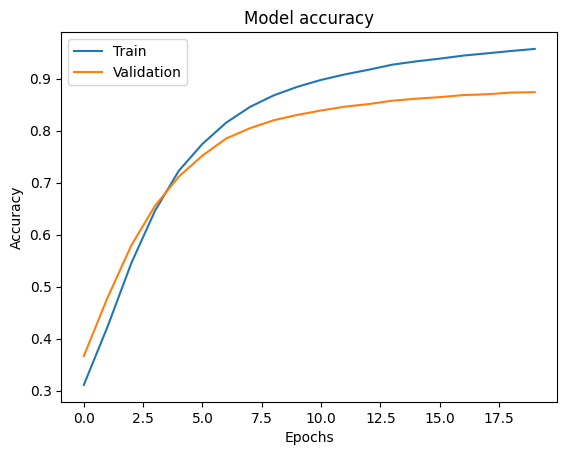

In [94]:
# plot results
plt.plot(history_baseline.history['accuracy'])
plt.plot(history_baseline.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [85]:
num_tags = Y_train.shape[2]

model1 = Sequential()
model1.add(Embedding(input_dim=len(sentence_tokenizer.word_index) + 1, output_dim=50, input_length=MAX_SEQ_LENGTH, weights=[embedding_train_matrix], trainable=True, mask_zero=True))
model1.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1)))
model1.add(Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1)))
model1.add(TimeDistributed(Dense(num_tags, activation="softmax")))

In [86]:
model1.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])

In [87]:
history_model1 = model1.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=128, epochs=20, verbose=1)

Epoch 1/20
16/16 [==============================] - 36s 2s/step - loss: 3.2167 - accuracy: 0.1356 - val_loss: 2.9257 - val_accuracy: 0.2116
Epoch 2/20
16/16 [==============================] - 27s 2s/step - loss: 2.8028 - accuracy: 0.2221 - val_loss: 2.7032 - val_accuracy: 0.2439
Epoch 3/20
16/16 [==============================] - 27s 2s/step - loss: 2.5480 - accuracy: 0.2878 - val_loss: 2.4088 - val_accuracy: 0.3568
Epoch 4/20
16/16 [==============================] - 25s 2s/step - loss: 2.1783 - accuracy: 0.4204 - val_loss: 2.0004 - val_accuracy: 0.4791
Epoch 5/20
16/16 [==============================] - 25s 2s/step - loss: 1.7463 - accuracy: 0.5441 - val_loss: 1.6418 - val_accuracy: 0.5567
Epoch 6/20
16/16 [==============================] - 25s 2s/step - loss: 1.4005 - accuracy: 0.6303 - val_loss: 1.3685 - val_accuracy: 0.6273
Epoch 7/20
16/16 [==============================] - 27s 2s/step - loss: 1.1414 - accuracy: 0.7070 - val_loss: 1.1572 - val_accuracy: 0.6955
Epoch 8/20
16/16 [==

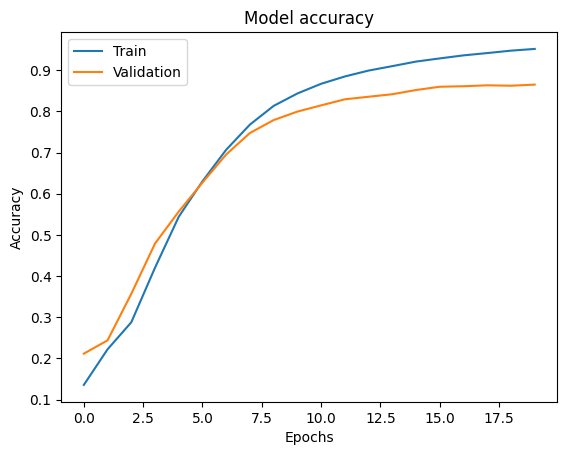

In [88]:
# plot results
plt.plot(history_model1.history['accuracy'])
plt.plot(history_model1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [101]:
num_tags = Y_train.shape[2]

model2 = Sequential()
model2.add(Embedding(input_dim=len(sentence_tokenizer.word_index) + 1 , output_dim=50, input_length=MAX_SEQ_LENGTH, weights=[embedding_train_matrix], trainable=True, mask_zero=True))
model2.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1)))
model2.add(TimeDistributed(Dense(num_tags*2, activation="softmax")))
model2.add(TimeDistributed(Dense(num_tags, activation="softmax")))

In [102]:
model2.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])

In [103]:
history_model2 = model2.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=128, epochs=20, verbose=1)

Epoch 1/20
16/16 [==============================] - 20s 924ms/step - loss: 3.8232 - accuracy: 0.0969 - val_loss: 3.7835 - val_accuracy: 0.0866
Epoch 2/20
16/16 [==============================] - 15s 927ms/step - loss: 3.7605 - accuracy: 0.1091 - val_loss: 3.7433 - val_accuracy: 0.0917
Epoch 3/20
16/16 [==============================] - 14s 905ms/step - loss: 3.7212 - accuracy: 0.1215 - val_loss: 3.7056 - val_accuracy: 0.0819
Epoch 4/20
16/16 [==============================] - 15s 935ms/step - loss: 3.6851 - accuracy: 0.1039 - val_loss: 3.6713 - val_accuracy: 0.0862
Epoch 5/20
16/16 [==============================] - 15s 927ms/step - loss: 3.6514 - accuracy: 0.1098 - val_loss: 3.6388 - val_accuracy: 0.0868
Epoch 6/20
16/16 [==============================] - 14s 902ms/step - loss: 3.6127 - accuracy: 0.1242 - val_loss: 3.5890 - val_accuracy: 0.1291
Epoch 7/20
16/16 [==============================] - 14s 903ms/step - loss: 3.5603 - accuracy: 0.1542 - val_loss: 3.5392 - val_accuracy: 0.1643

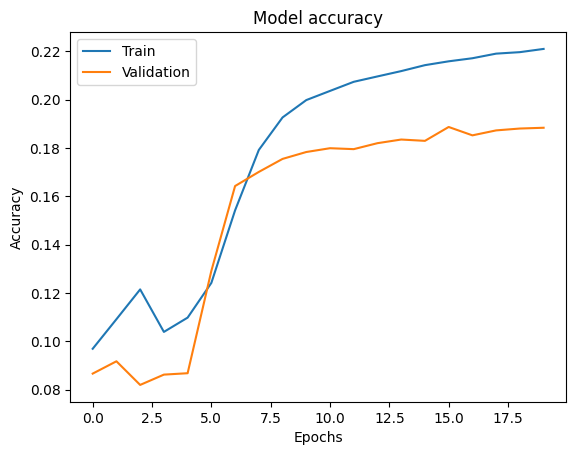

In [104]:
# plot results
plt.plot(history_model2.history['accuracy'])
plt.plot(history_model2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# METRICS

In [28]:
tag2idx = tag_tokenizer.word_index
idx2tag = {i: w for w, i in tag2idx.items()}
print(idx2tag)

{1: '<UNK>', 2: 'nn', 3: 'nnp', 4: 'in', 5: 'dt', 6: 'nns', 7: 'jj', 8: ',', 9: '.', 10: 'vbd', 11: 'rb', 12: 'cd', 13: 'vb', 14: 'cc', 15: 'vbz', 16: 'vbn', 17: 'to', 18: 'prp', 19: 'vbg', 20: 'vbp', 21: 'md', 22: 'prp$', 23: '``', 24: 'pos', 25: "''", 26: '$', 27: ':', 28: 'wdt', 29: 'jjr', 30: 'wp', 31: 'rp', 32: 'nnps', 33: 'jjs', 34: 'wrb', 35: 'rbr', 36: '-rrb-', 37: '-lrb-', 38: 'ex', 39: 'rbs', 40: 'ls', 41: 'pdt', 42: 'wp$', 43: 'fw', 44: 'uh', 45: 'sym', 46: '#'}


In [36]:
# get y values for . , oov and pad
print(Y_test.shape)
print(Y_test[0])

(638, 100)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  3  3  3  8  3  3  8  3  8 10 18 10
 12 12  6  8 14  4 12  2  8  4 22  7  2  4  5  7  2  4 26 12  5  2  8 14
 26 12 12  9]


In [56]:
# print all tags
print(tag2idx)
# print index of punctuation marks (. , ? ! " ' - : ; )
punctuation_tags = [',', '.', '?', '!', '"', "'", '-', ':', ';' , '<UNK>', '(', ')', '[', ']', '{', '}', '<', '>']
punctuation_tags_idx = []
for tag in punctuation_tags:
    try:
        print(f'{tag}: {tag2idx[tag]}')
        punctuation_tags_idx.append(tag2idx[tag])
    except KeyError:
        continue

{'<UNK>': 1, 'nn': 2, 'nnp': 3, 'in': 4, 'dt': 5, 'nns': 6, 'jj': 7, ',': 8, '.': 9, 'vbd': 10, 'rb': 11, 'cd': 12, 'vb': 13, 'cc': 14, 'vbz': 15, 'vbn': 16, 'to': 17, 'prp': 18, 'vbg': 19, 'vbp': 20, 'md': 21, 'prp$': 22, '``': 23, 'pos': 24, "''": 25, '$': 26, ':': 27, 'wdt': 28, 'jjr': 29, 'wp': 30, 'rp': 31, 'nnps': 32, 'jjs': 33, 'wrb': 34, 'rbr': 35, '-rrb-': 36, '-lrb-': 37, 'ex': 38, 'rbs': 39, 'ls': 40, 'pdt': 41, 'wp$': 42, 'fw': 43, 'uh': 44, 'sym': 45, '#': 46}
,: 8
.: 9
:: 27
<UNK>: 1


In [72]:
# Metrics: Macro F1 score over all tokens, do not consider punctuation
from sklearn.metrics import f1_score

def macro_f1(y_true, y_pred):
    print(y_true.shape)
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)
    print(y_true.shape)
    print(y_pred.shape)
    # remove punctuation tags from y_true
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    print(y_true.shape)
    print(y_pred.shape)
    print(y_true[38349])
    temp = [] 
    temp_pred = []
    for i in range(len(y_true)):
        if y_true[i] not in punctuation_tags_idx and y_true[i] != 0:
            temp.append(y_true[i])
            temp_pred.append(y_pred[i])
    print(len(temp))
    print(len(temp_pred))
    return f1_score(temp, temp_pred, average='macro')
    # remove 0 from y_true
    # y_true = y_true[y_true != 0]
    # print(y_true[0:10])
    # print(y_true.shape)
    # print(y_pred.shape)
    # remove pad from y_true
    # y_true = y_true[y_true != 0]
    # remove pad from y_pred
    # y_pred = y_pred[y_pred != 0]
    # print(y_true.shape)
    # print(y_pred.shape)
    #return f1_score(y_true, y_pred, average='macro')
            

In [99]:
# Evaluate the models
print("Baseline model")
print("Train accuracy: {}".format(baseline.evaluate(X_train, Y_train)[1]))
print("Validation accuracy: {}".format(baseline.evaluate(X_val, Y_val)[1]))
print("Test accuracy: {}".format(baseline.evaluate(X_test, Y_test)[1]))
print("Macro F1 score: {}".format(macro_f1(Y_test, baseline.predict(X_test))))

Baseline model
62/62 [==============================] - 3s 46ms/step - loss: 0.1657 - accuracy: 0.9606
Train accuracy: 0.9606197476387024
40/40 [==============================] - 2s 47ms/step - loss: 0.4565 - accuracy: 0.8741
Validation accuracy: 0.8740980625152588
20/20 [==============================] - 1s 45ms/step - loss: 0.4143 - accuracy: 0.8825
Test accuracy: 0.8825345635414124
20/20 [==============================] - 1s 44ms/step
(638, 100, 47)
(638, 100)
(638, 100)
(63800,)
(63800,)
0
14064
14064
Macro F1 score: 0.7575740651709005


In [89]:
# Evaluate the models
print("Model 1")
print("Train accuracy: {}".format(model1.evaluate(X_train, Y_train)[1]))
print("Validation accuracy: {}".format(model1.evaluate(X_val, Y_val)[1]))
print("Test accuracy: {}".format(model1.evaluate(X_test, Y_test)[1]))
print("Macro F1 score: {}".format(macro_f1(Y_test, model1.predict(X_test))))

Model 1
62/62 [==============================] - 6s 91ms/step - loss: 0.1898 - accuracy: 0.9566
Train accuracy: 0.9565503001213074
40/40 [==============================] - 4s 90ms/step - loss: 0.4909 - accuracy: 0.8652
Validation accuracy: 0.8651508688926697
20/20 [==============================] - 2s 90ms/step - loss: 0.4469 - accuracy: 0.8750
Test accuracy: 0.8750080466270447
20/20 [==============================] - 3s 89ms/step
(638, 100, 47)
(638, 100)
(638, 100)
(63800,)
(63800,)
0
14064
14064
Macro F1 score: 0.7307873862695964


In [105]:
# Evaluate the models
print("Model 2")
print("Train accuracy: {}".format(model2.evaluate(X_train, Y_train)[1]))
print("Validation accuracy: {}".format(model2.evaluate(X_val, Y_val)[1]))
print("Test accuracy: {}".format(model2.evaluate(X_test, Y_test)[1]))
print("Macro F1 score: {}".format(macro_f1(Y_test, model2.predict(X_test))))

Model 2
62/62 [==============================] - 3s 51ms/step - loss: 3.1233 - accuracy: 0.2225
Train accuracy: 0.22248362004756927
40/40 [==============================] - 2s 49ms/step - loss: 3.1406 - accuracy: 0.1884
Validation accuracy: 0.18837186694145203
20/20 [==============================] - 1s 51ms/step - loss: 3.1244 - accuracy: 0.2045
Test accuracy: 0.20450305938720703
20/20 [==============================] - 1s 49ms/step
(638, 100, 47)
(638, 100)
(638, 100)
(63800,)
(63800,)
0
14064
14064
Macro F1 score: 0.018551858359748843
